In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import shap
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

def focal_loss(alpha=0.75, gamma=2):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        return -K.mean(alpha*y_true*K.pow(1-y_pred, gamma)*K.log(y_pred) +
                       (1-alpha)*(1-y_true)*K.pow(y_pred, gamma)*K.log(1-y_pred))
    return loss


# Sistem Ayarları
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

# 1. ATTENTION LAYER (Zaman serisindeki kritik anları öğrenir)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="glorot_uniform")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(K.squeeze(e, axis=-1))
        a = K.expand_dims(a, axis=-1)
        return K.sum(x * a, axis=1)

# 2. DATA LOADING & PREPROCESSING
DATA_PATH = "../data/"
info = pd.read_csv(DATA_PATH + "studentInfo.csv.zip", compression="zip")
assess = pd.read_csv(DATA_PATH + "studentAssessment.csv.zip", compression="zip")
vle = pd.read_csv(DATA_PATH + "studentVle.csv.zip", compression="zip")

# Target: 1=Success, 0=At-Risk
info["target"] = info["final_result"].apply(lambda x: 1 if x in ["Pass", "Distinction"] else 0)

# Categorical Encoding
cat_cols = ["gender", "region", "highest_education", "imd_band", "age_band", "disability"]
le = LabelEncoder()
for col in cat_cols:
    info[col] = le.fit_transform(info[col].astype(str))

# VLE Features (Interaction)
vle_feat = vle.groupby("id_student")["sum_click"].agg(["mean", "sum"]).reset_index().fillna(0)
vle_feat.columns = ["id_student", "vle_mean", "vle_total"]

# Exam Sequences (Temporal)
assess["score"] = assess["score"].fillna(0)
grade_seq = assess.sort_values("date_submitted").groupby("id_student")["score"].apply(list).reset_index()

# Merging
df = pd.merge(info, grade_seq, on="id_student", how="inner")
df = pd.merge(df, vle_feat, on="id_student", how="left").fillna(0)

# Feature Matrices
MAX_LEN = 12
X_seq = pad_sequences(df["score"], maxlen=MAX_LEN, padding="post", dtype="float32")
static_cols = cat_cols + ["num_of_prev_attempts", "studied_credits", "vle_mean", "vle_total"]
X_static = df[static_cols].values
X_combined = np.hstack([X_static, X_seq])
y = df["target"].values

print("Blok 1 Tamamlandı: Veriler akademik formata hazırlandı.")

Blok 1 Tamamlandı: Veriler akademik formata hazırlandı.


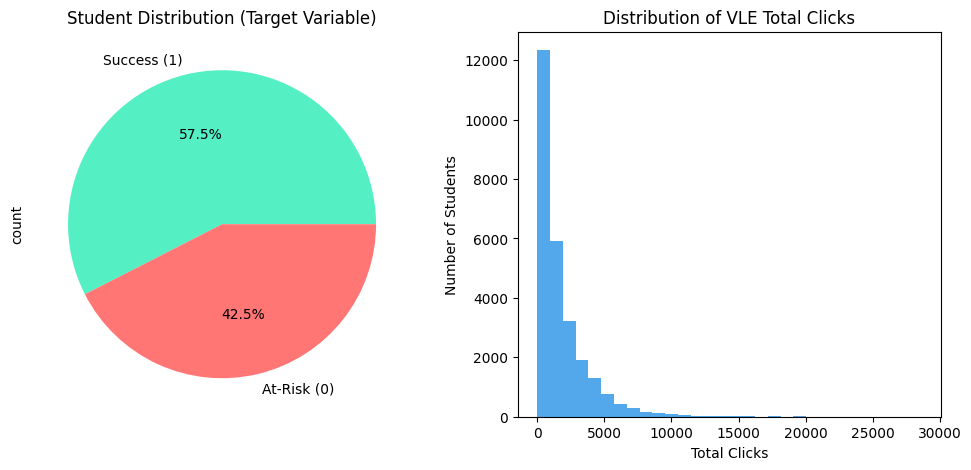

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 22, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 22, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 256)                 │             278 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,679 (526.09 KB)

 Trainable params: 134,167 (524.09 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7830 - loss: 0.0620 - val_accuracy: 0.7746 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 2/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7889 - loss: 0.0472 - val_accuracy: 0.8019 - val_loss: 0.0598 - learning_rate: 0.0010
Epoch 3/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7938 - loss: 0.0443 - val_accuracy: 0.6619 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 4/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7965 - loss: 0.0439 - val_accuracy: 0.8168 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 5/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7966 - loss: 0.0431 - val_accuracy: 0.7721 - val_loss: 0.0531 - learning_rate: 0.0010
Epoch 6/15
334/335 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7992 - loss: 0.0428
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7948 - loss: 0.

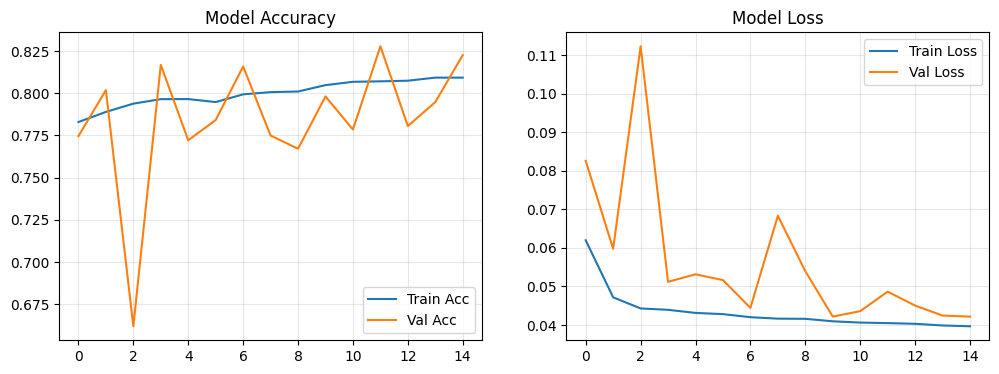

In [2]:
# 1. DATA VISUALIZATION (VERİ ANALİZİ)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['target'].value_counts().plot(kind='pie', labels=['Success (1)', 'At-Risk (0)'], autopct='%1.1f%%', colors=['#55efc4', '#ff7675'])
plt.title("Student Distribution (Target Variable)")

plt.subplot(1, 2, 2)
plt.hist(df['vle_total'], bins=30, color='#0984e3', alpha=0.7)
plt.title("Distribution of VLE Total Clicks")
plt.xlabel("Total Clicks"); plt.ylabel("Number of Students")
plt.show()

# 2. TRAIN-TEST SPLIT & CLASS WEIGHTS
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cw = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: cw[0], 1: cw[1]}

# 3. MODEL DEFINITION
inp = Input(shape=(X_train_3d.shape[1], 1))
x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))(inp)
x = AttentionLayer()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=focal_loss(),
              metrics=["accuracy"])

model.summary()


# 4. TRAINING
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
history = model.fit(X_train_3d, y_train, epochs=15, batch_size=64, validation_data=(X_test_3d, y_test), 
                    class_weight=class_weight_dict, callbacks=[lr_scheduler], verbose=1)

# 5. TRAINING CURVES (EĞİTİM GRAFİKLERİ)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc'); plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss'); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Optimal Threshold = 0.564

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

     At-Risk       0.84      0.75      0.79      2273
     Success       0.83      0.89      0.86      3077

    accuracy                           0.83      5350
   macro avg       0.83      0.82      0.82      5350
weighted avg       0.83      0.83      0.83      5350



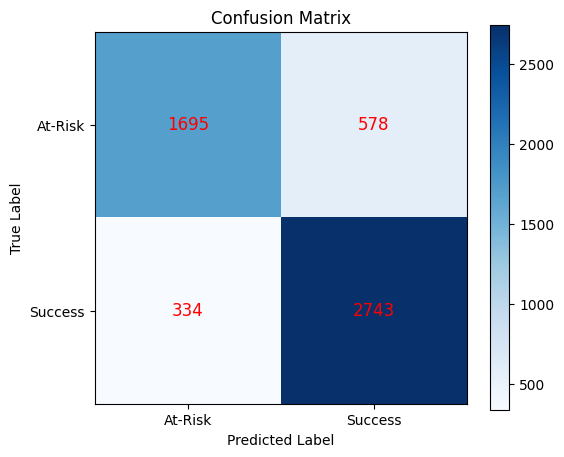

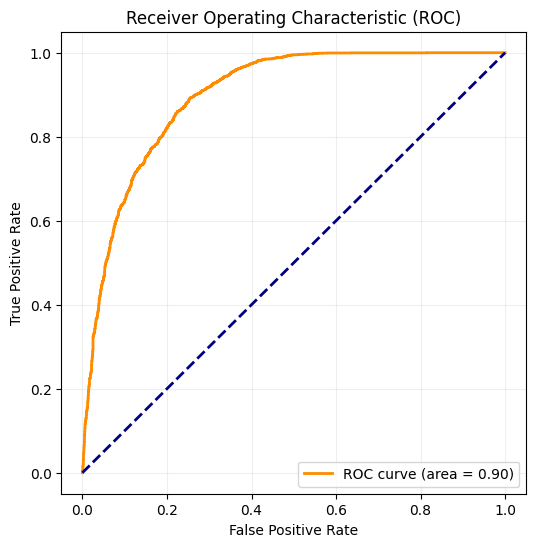


>>> Generating SHAP Summary Plot...


  0%|          | 0/10 [00:00<?, ?it/s]

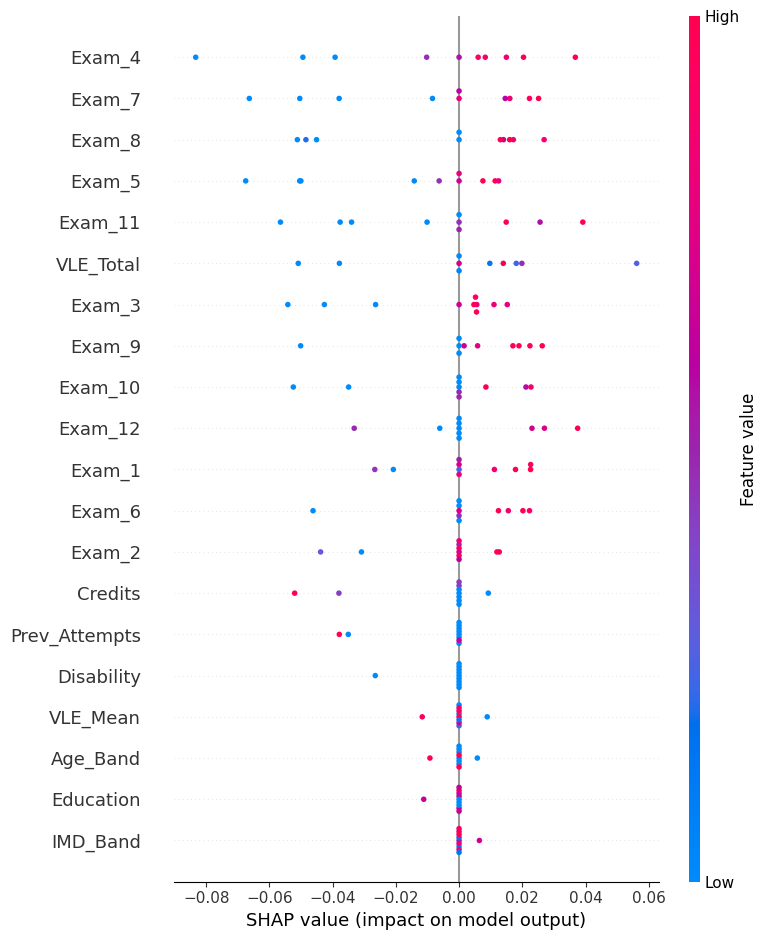

In [3]:
# 1. PERFORMANCE EVALUATION
y_prob = model.predict(X_test_3d).flatten()
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_prob)
best_thr = thr[np.argmax(tpr - fpr)]

print("Optimal Threshold =", round(best_thr,3))

best_thr = thr[np.argmax(tpr - fpr)]
y_pred = (y_prob > best_thr).astype(int)

from sklearn.metrics import roc_curve

print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=['At-Risk', 'Success']))

# 2. CONFUSION MATRIX (KARMAŞIKLIK MATRİSİ)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = ['At-Risk', 'Success']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes); plt.yticks(tick_marks, classes)
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="red", fontsize=12)
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()

# 3. ROC CURVE
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right"); plt.grid(True, alpha=0.2)
plt.show()

# 4. SHAP GLOBAL INTERPRETABILITY (İNGİLİZCE ETİKETLER)
def predict_fn(data_2d):
    return model.predict(data_2d.reshape(data_2d.shape[0], data_2d.shape[1], 1), verbose=0).flatten()

# FEATURE NAMES IN ENGLISH
english_feature_names = (
    ["Gender", "Region", "Education", "IMD_Band", "Age_Band", "Disability", 
     "Prev_Attempts", "Credits", "VLE_Mean", "VLE_Total"] + 
    [f"Exam_{i+1}" for i in range(MAX_LEN)]
)

print("\n>>> Generating SHAP Summary Plot...")
explainer = shap.KernelExplainer(predict_fn, X_train[:30]) # Background 30
shap_values = explainer.shap_values(X_test[:10], nsamples=100) # Test 10

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test[:10], feature_names=english_feature_names)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


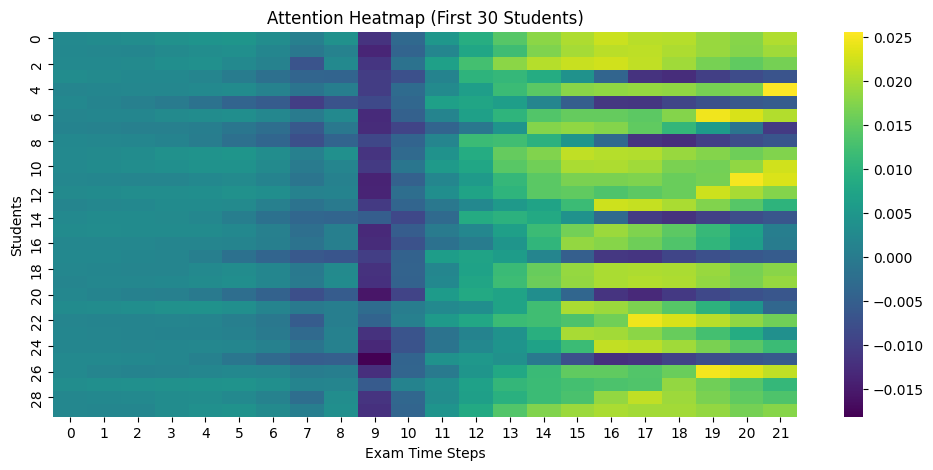

In [4]:
attention_model = Model(inputs=model.input,
                         outputs=model.layers[1].output)

attention_output = attention_model.predict(X_test_3d[:200])
attention_scores = np.mean(attention_output, axis=2)

plt.figure(figsize=(12,5))
sns.heatmap(attention_scores[:30], cmap="viridis")
plt.title("Attention Heatmap (First 30 Students)")
plt.xlabel("Exam Time Steps")
plt.ylabel("Students")
plt.show()


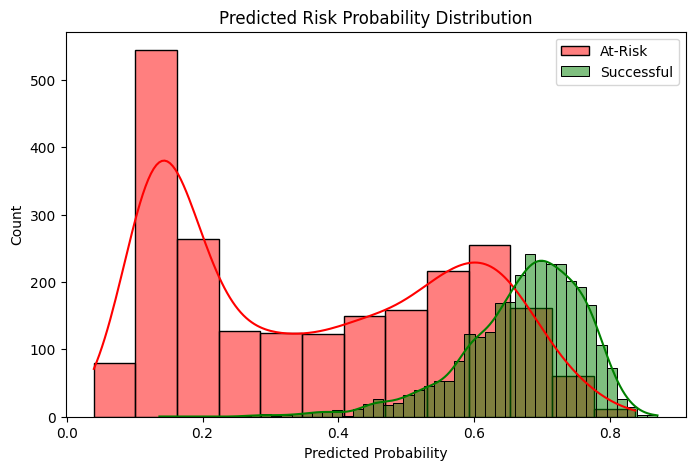

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(y_prob[y_test==0], color="red", label="At-Risk", kde=True)
sns.histplot(y_prob[y_test==1], color="green", label="Successful", kde=True)
plt.title("Predicted Risk Probability Distribution")
plt.xlabel("Predicted Probability")
plt.legend()
plt.show()


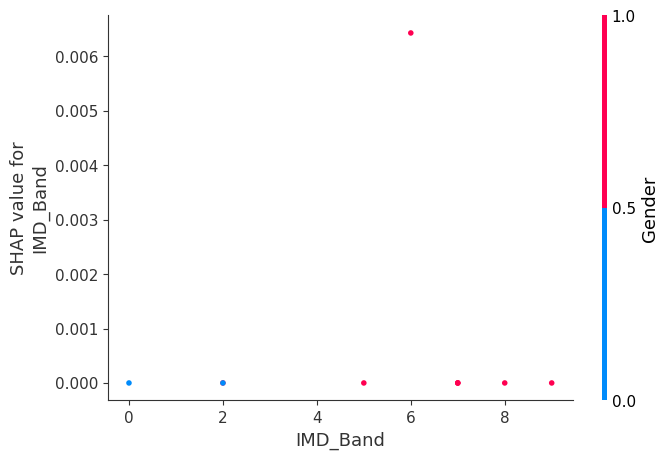

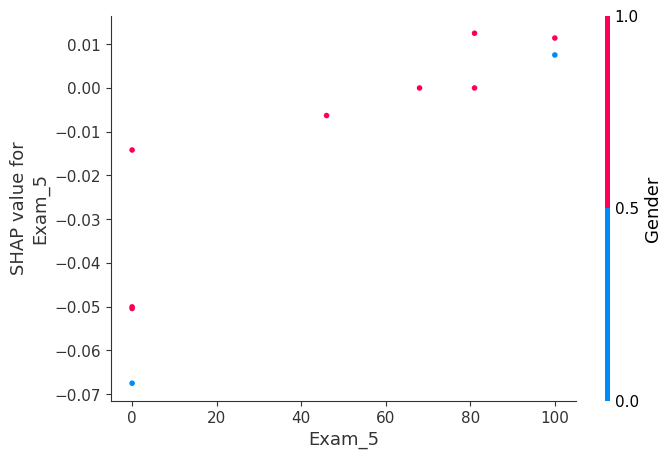

In [6]:
shap.dependence_plot("IMD_Band", shap_values, X_test[:10], feature_names=english_feature_names)
shap.dependence_plot("Exam_5", shap_values, X_test[:10], feature_names=english_feature_names)


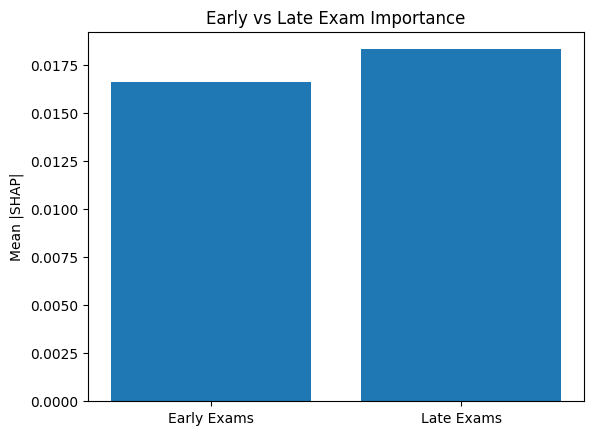

In [7]:
exam_shap = np.abs(shap_values[:, 10:])  # Only exam features
early = exam_shap[:, :6].mean()
late = exam_shap[:, 6:].mean()

plt.bar(["Early Exams", "Late Exams"], [early, late])
plt.title("Early vs Late Exam Importance")
plt.ylabel("Mean |SHAP|")
plt.show()


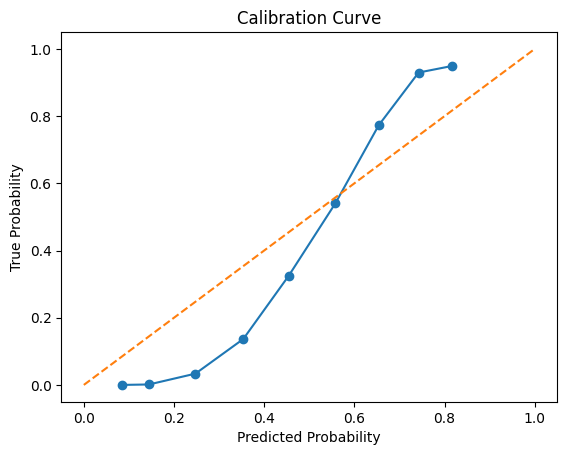

In [8]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()


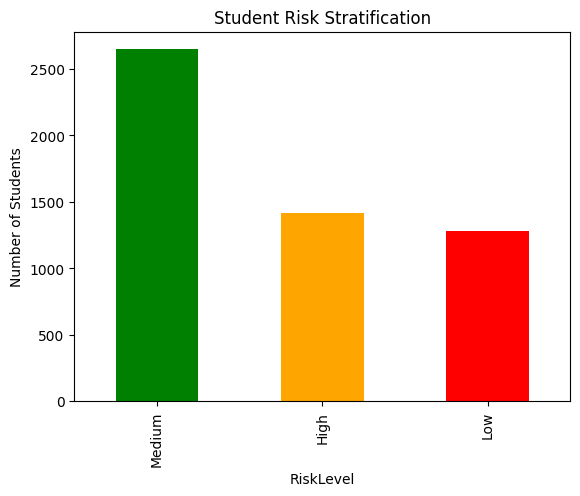

In [9]:
risk_df = pd.DataFrame({
    "TrueLabel": y_test,
    "RiskProb": y_prob
})

risk_df["RiskLevel"] = pd.cut(risk_df["RiskProb"],
                              bins=[0,0.4,0.7,1],
                              labels=["Low","Medium","High"])

risk_df["RiskLevel"].value_counts().plot(kind="bar", color=["green","orange","red"])
plt.title("Student Risk Stratification")
plt.ylabel("Number of Students")
plt.show()


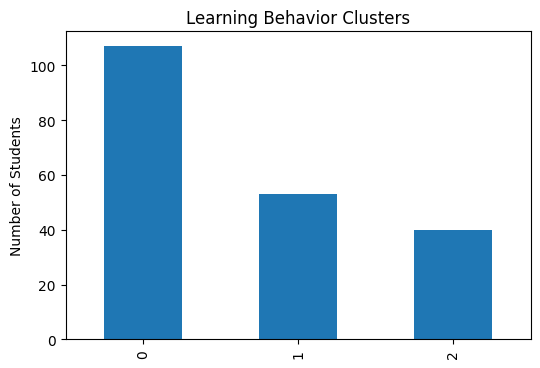

In [13]:
from sklearn.cluster import KMeans
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

A = attention_scores
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42).fit(A)

clusters = kmeans.labels_

plt.figure(figsize=(6,4))
pd.Series(clusters).value_counts().plot(kind="bar")
plt.title("Learning Behavior Clusters")
plt.ylabel("Number of Students")
plt.show()
